# Variational Coin Toss

Code originally came from [this blog post](http://www.openias.org/variational-coin-toss).

Stochastic Variational Inference with Reparameterization Section is reimplemented with PyTorch Library.

In [76]:
import numpy as np
import scipy.stats as scs
import scipy.special as scf
import scipy.optimize as sco
np.random.seed(733)

import matplotlib
import matplotlib.pyplot as plt

### Ploting example for Beta distribution

In [98]:
z_space = np.linspace(0, 1, 250)
p_z = scs.beta(3, 3).pdf(z_space)  # "p_z" is Beta[3, 3] distribution 

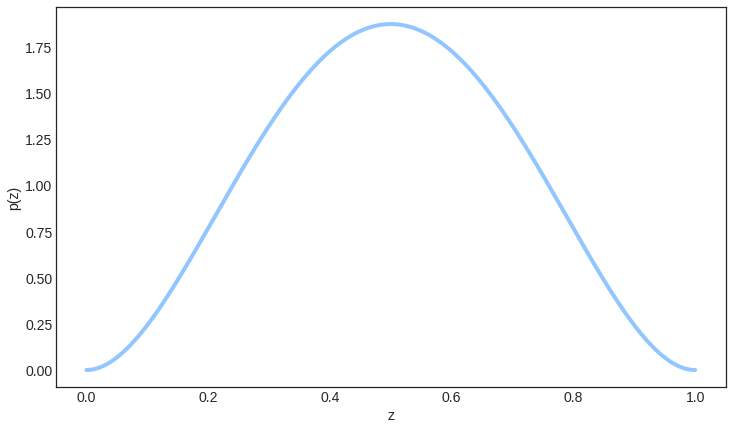

In [99]:
matplotlib.rcParams.update({'font.size': 14})
plt.style.use(['seaborn-pastel', 'seaborn-white'])
plt.figure(figsize=(12, 7))
plt.plot(z_space, p_z, linewidth=4.)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

### Generate some data from the generative model for our experiment
- A True Beta Prior : p(z) = Beta(3,3) and Bernoulli Likelihood p(x|z)
- we actually sample some data $x$ for the experiment.

In [109]:
true_z = scs.beta.rvs(3, 3)
x = scs.bernoulli.rvs(true_z, size=30)
print('z =', true_z)
print('x =', x)

z = 0.3517944567782077
x = [0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1]


### Define KL divergence between Beta and Beta.
we also define expected log bernoulli likelihood with respect to Beta distribution

In [110]:
# See https://en.wikipedia.org/wiki/Beta_distribution#Quantities_of_information_.28entropy.29
def KL(a2, b2, a1, b1):
    """Returns the Kullback-Leibler divergence between Beta[a2, b2] and Beta[a1, b1]"""
    #print "KL(Beta[3, 3] || Beta[1, 1]) = ", KL(3, 3, 1, 1)
    #print "KL(Beta[.5,3] || Beta[3,.5]) = ", KL(0.5, 3, 3, 0.5)
    return (np.log(scf.beta(a1, b1) / scf.beta(a2, b2)) + (a2 - a1) * scf.psi(a2) + (b2 - b1) * scf.psi(b2) +
            (a1 - a2 + b1 - b2) * scf.psi(a2 + b2))

# See https://en.wikipedia.org/wiki/Beta_distribution#Geometric_mean
def E_log_p_x_z(x, a2, b2):
    """Returns the expected value of log p(x | z) over z ~ Beta[a2, b2]"""
    return ((x == 1).sum() * (scf.psi(a2) - scf.psi(a2 + b2)) +
            (x == 0).sum() * (scf.psi(b2) - scf.psi(a2 + b2)))

### Analytical KL divergnece objective KL(q(z)|p(z|x))

In [111]:
def objective(a2b2):
    return (KL(a2b2[0],a2b2[1],3,3)-E_log_p_x_z(x,a2b2[0],a2b2[1]))

q_trace = [p_z]

res = sco.minimize(objective, [3,3], callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z_space)))
print(res.message)

Optimization terminated successfully.


### Code for optimization animition

In [112]:
"""
Derived from

Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
from matplotlib import animation

def generate_animation(qs):
    # True Posterior distribution P(z|x) = beta(3+n(x=1),3+n(x=0))
    p_z_x = scs.beta(3+(x == 1).sum(), 3+(x == 0).sum()).pdf(z_space) 

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(xlim=(0, 1), ylim=(0, 1.1 * p_z_x.max()))
    ax.set_xlabel('z')
    
    # Ploting Initial Prior distribution P(z) and True Posterior distribution P(z|x). 
    ax.plot(z_space, p_z, linewidth=4., label='p(z)')
    ax.plot(z_space, p_z_x, linewidth=4., linestyle='--', dashes=(5, 1), label='p(z | x)')
    
    # Draw auto-located Legend
    approx, = ax.plot([], [], linewidth=2., label='q(z)')
    ax.legend(loc=2 if (x == 1).sum() >= (x == 0).sum() else 1)

    # Ploting Our estimation: Q(z) Distribution
    def init():     # initialization function: plot the background of each frame
        approx.set_data([], [])
        return approx,

    # animation function.  This is called sequentially
    def animate(i):
        if i >= len(qs):
            i = len(qs) - 1
        approx.set_data(z_space, qs[i])
        return approx,
    interval = 1000 * 15 // len(qs)
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=(len(qs) + (5000 // interval)), interval=interval, blit=True)
    plt.close()
    
    return anim.to_html5_video()

In [113]:
from IPython.core.display import HTML
html = generate_animation(q_trace)
#with open("variational_coin_closedform.html", "w") as f:
#    f.write(html)
HTML(html)

### Monte Carlo Approximation of KL(q(z)||p(z|x))

In [114]:
eps = np.finfo(np.float32).eps
N = 10000                            # number of sample 10000:

def monte_carlo_estimate(a2b2):
    """Returns an estimate of the objective based on Monte Carlo integration"""
    if a2b2[0] < 0.0 or a2b2[1] < 0.0:
        return np.inf
    
    p = scs.beta(3, 3)               # p(z;3,3)
    q = scs.beta(a2b2[0], a2b2[1])   # q(z; parm1, parm2) 
    s_z = q.rvs(size=N)              # n z ~ q(z; parm1, parm2)

    s_p_z = p.pdf(s_z) + eps         # pdf value p(z_i)
    s_q_z = q.pdf(s_z) + eps         # pdf value q(z_i)
            
    return (1. / N) * (np.log(s_q_z / s_p_z) - (x == 1).sum() * np.log(s_z) - (x == 0).sum() * np.log(1 - s_z)).sum()


q_trace = [p_z]
res = sco.minimize(monte_carlo_estimate, [3,3], method='Powell', callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z_space)))

print(res.message)

Optimization terminated successfully.


In [115]:
from IPython.core.display import HTML
html = generate_animation(q_trace)
#with open("variational_coin_mcint.html", "w") as f:
#    f.write(html)
HTML(html)

### Stochastic Variational Inference with Reparameterization (Pytorch Version)

In [116]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
tc.manual_seed(733)

def gammaln(x):
    value = Variable(tc.Tensor([0]))
    for i in tc.arange(x)[1:]:
        value += Variable(tc.log(tc.Tensor([i])))
    return value

def log_gaussian_logsigma(x, mu, logsigma):
    return -0.5 * tc.log(2 * Variable(tc.Tensor([np.pi])) - q_logsigma - (x - q_mu) ** 2 / (2. * tc.exp(2. * q_logsigma)))

def log_beta(x, a, b):
    return (a - 1) * tc.log(x) + (b - 1) * tc.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

In [117]:
prior_a, prior_b = 3, 3
q_mu = Variable(tc.Tensor([float(prior_a) / (prior_a + prior_b)]), requires_grad=True)
q_logsigma = Variable(tc.Tensor([0.5 * np.log(float(prior_a * prior_b) / ((prior_a + prior_b)**2 * (prior_a + prior_b + 1)))]), requires_grad=True)

optimizer = optim.RMSprop([q_mu,q_logsigma], lr=0.01, momentum=0.05)

def KL_cost_fn(q_mu,q_logsigma,n_samples=10):
    KL_objective = Variable(tc.zeros(1))

    for sample in range(n_samples):    
        sample_z = q_mu + tc.exp(q_logsigma) * Variable(tc.randn(1))
        log_q_z = log_gaussian_logsigma(sample_z, q_mu, q_logsigma)
        log_p_z = log_beta(sample_z, prior_a, prior_b)
        log_p_x_z = Variable(tc.Tensor([int((x == 1).sum())])) * tc.log(sample_z) \
                  + Variable(tc.Tensor([int((x == 0).sum())])) * tc.log(1 - sample_z)
        
        KL_objective += (log_q_z - log_p_z - log_p_x_z).sum() / n_samples
    return KL_objective 

q_trace = [scs.norm(q_mu.data.numpy(), np.exp(q_logsigma.data.numpy())).pdf(z_space)]

for epoch in range(250):
    cost = KL_cost_fn(q_mu,q_logsigma) 
    cost.backward()                     # compute gradient value of parameters (q_mu, q_logsigma)
    optimizer.step()                    # update gradients !! 
    optimizer.zero_grad()               # clear gradients for next traing

    q_trace.append(scs.norm(q_mu.data.numpy(), np.exp(q_logsigma.data.numpy())).pdf(z_space))
    
    

In [97]:
from IPython.core.display import HTML
html = generate_animation(q_trace)
#with open("variational_coin_sgd.html", "w") as f:
#    f.write(html)
HTML(html)